In [ ]:
import re
import pickle
from typing import List
from dotenv import load_dotenv # e.g., MLFLOW_TRACKING_PASSWORD, MLFLOW_TRACKING_USERNAME
from collections import Counter
from itertools import chain, islice

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for classical machine learning
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            f1_score, accuracy_score, roc_auc_score, \
                            precision_score, recall_score

# Libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
# unfortunately the functions below aren't available.
# GitHub (as of 3rd Nov. 2024): https://github.com/pytorch/text/issues/2272
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

# utility functions
from faiq_utils import make_confusion_matrix

load_dotenv()
%matplotlib inline

In [2]:
# experiment tracking
import mlflow.sklearn
import mlflow.pytorch
from mlflow.models.signature import infer_signature

remote_server_uri = "https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow"
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_id="1")

<Experiment: artifact_location='mlflow-artifacts:/7e4f65f8548a456da35a3ee33ee26732', creation_time=1731770030030, experiment_id='1', last_update_time=1731770030030, lifecycle_stage='active', name='genshin-impact-sentiment-analysis', tags={}>

### 1.0 Load cleaned stemmed dataset

In [6]:
# Read the clean dataset
reviews_train = pd.read_csv('../data/clean_train_stem.csv')
reviews_test = pd.read_csv('../data/clean_test_stem.csv')

In [7]:
# View the first 5 rows of the Train dataset
reviews_train.head()

,content,content_stem,score,target
0,My game was great! I play it on the pc too! Bu...,pc sinc recent updat work phone samsung e work...,3,1
1,This game is awesome but my phone doesn't have...,awesom phone storag long lastli delet soon,3,1
2,Your game is great I like the way you can tell...,way tell region base buy use real peopl white ...,2,1
3,I've been playing this game for more than a ye...,year say addict reason gave star login suck pc...,1,1
4,Maybe get it if you can't play breath of the w...,mayb get breath wild feel bland otherwis compe...,2,1


In [8]:
# 6472 documents in our dataset
reviews_train.shape

(6472, 4)

In [9]:
# Check the data types
reviews_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6472 entries, 0 to 6471
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       6472 non-null   object
 1   content_stem  6472 non-null   object
 2   score         6472 non-null   int64 
 3   target        6472 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 202.4+ KB


In [10]:
# Establish our baseline score
reviews_train['target'].value_counts(normalize=True)

target
1    0.601978
0    0.398022
Name: proportion, dtype: float64

Given that the majority class is class 1 (negative reviews), our **baseline score** is an accuracy of **0.60**. The baseline score will serve as a point of comparison when evaluating our models.

In [11]:
X_train = reviews_train['content_stem']
y_train = reviews_train['target']

In [12]:
X_test = reviews_test['content_stem']
y_test = reviews_test['target']

In [13]:
X_train.shape

(6472,)

In [14]:
X_test.shape

(1619,)

In [15]:
y_train.value_counts(normalize=True)

target
1    0.601978
0    0.398022
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

target
1    0.601606
0    0.398394
Name: proportion, dtype: float64

We'll now use the CountVectorizer() to check how many unique words there are. Overall, there are 6643 words in our corpus. When we add bi-grams into the picture, we have 87090 uni/bi-grams in total.

In [17]:
cvec_1 = CountVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
cvec_1_df = pd.DataFrame(cvec_1.fit_transform(X_train).todense(), columns=cvec_1.get_feature_names_out())

cvec_1_df.shape

(6472, 6643)

In [18]:
cvec_2 = CountVectorizer(stop_words = 'english', ngram_range=(1, 2)) 
cvec_2_df = pd.DataFrame(cvec_2.fit_transform(X_train).todense(), columns=cvec_2.get_feature_names_out())

cvec_2_df.shape

(6472, 87090)

### 2.0 Modeling

We will explore both classical machine learning and deep learning for sentiment analysis. The **production model will be selected based on recall** and accuracy **on the validation set**. In this case, we'd like the model to minimize False Negatives as:

- Not reaching out to/responding to feedback from a negative review may be seen as poor engagement from a customer's point of view. Hence, we'll need to identify as many negative reviews as possible.
- The cost of a False Positive (classifying a positive review as negative) is not costly as the staff can choose to ignore such feedback and recategorize it as positive.

#### 2.1 Classical Machine Learning

We will use the Bag of Words (BoW) representation to extract features from the text. This will be done through vectorization, specifically the CountVectorizer and TF-IDF Vectorizer. The CountVectorizer simply tokenizes and counts the word occurrences in our corpus. While on the other hand, TF-IDF tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

After vectorizing, we will fit a Logistic Regression, Naive Bayes and Support Vector Machine on the training data and evaluate the models' performance on the validation set.

##### 2.1.1 Count Vectorizer & Logistic Regression

In [22]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1), (1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

with mlflow.start_run():
    # Instantiate GridSearchCV
    gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # Objects to optimise
                            param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                            cv=10) # 10-fold cross validation

    # Fit model on to training data
    gs_cvec_lr.fit(X_train, y_train)

    # Generate predictions on validation set
    cvec_lr_pred = gs_cvec_lr.predict(X_test)

    signature = infer_signature(X_test, cvec_lr_pred)

    mlflow.log_params(gs_cvec_lr.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, cvec_lr_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, cvec_lr_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, cvec_lr_pred))
    mlflow.log_metric("Precision", precision_score(y_test, cvec_lr_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_cvec_lr,
        "model",
        registered_model_name="Count Vectorizer & Logistic Regression",
        signature=signature
    )

# Print accuracy scores
print('')
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_lr_pred))

Successfully registered model 'Count Vectorizer & Logistic Regression'.
2024/11/16 23:21:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Count Vectorizer & Logistic Regression, version 1
Created version '1' of model 'Count Vectorizer & Logistic Regression'.
2024/11/16 23:21:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-doe-153 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/636046f0cab54aaab2198516355bd8ea.
2024/11/16 23:21:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.741958612399107
Training score: 0.7682323856613102
Validation score: 0.7374922791846819

              precision    recall  f1-score   support

           0       0.73      0.55      0.62       645
           1       0.74      0.86      0.80       974

    accuracy                           0.74      1619
   macro avg       0.73      0.71      0.71      1619
weighted avg       0.74      0.74      0.73      1619



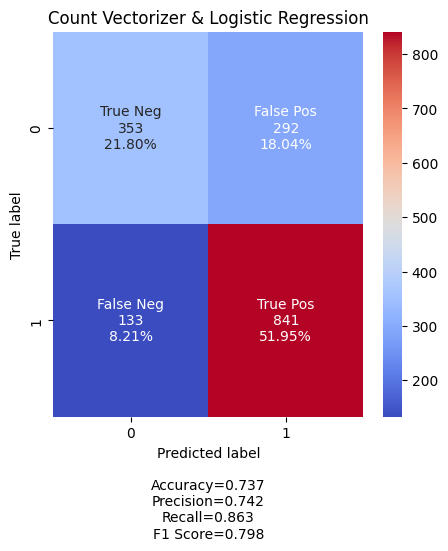

In [26]:
cm_gd = confusion_matrix(y_test, cvec_lr_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer & Logistic Regression"
)

##### 2.1.2 TF-IDF Vectorizer & Logistic Regression

In [23]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50],
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01, .1, 1]
}

with mlflow.start_run():
    # Instantiate GridSearchCV
    gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                            param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                            cv=10) # 10-fold cross validation

    # Fit model on to training data
    gs_tvec_lr.fit(X_train, y_train)

    # Generate predictions on validation set
    tvec_lr_pred = gs_tvec_lr.predict(X_test)

    signature = infer_signature(X_test, tvec_lr_pred)

    mlflow.log_params(gs_tvec_lr.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, tvec_lr_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, tvec_lr_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, tvec_lr_pred))
    mlflow.log_metric("Precision", precision_score(y_test, tvec_lr_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_cvec_lr,
        "model",
        registered_model_name="TF-IDF Vectorizer & Logistic Regression",
        signature=signature
    )

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_lr_pred))

Successfully registered model 'TF-IDF Vectorizer & Logistic Regression'.
2024/11/16 23:30:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TF-IDF Vectorizer & Logistic Regression, version 1
Created version '1' of model 'TF-IDF Vectorizer & Logistic Regression'.
2024/11/16 23:30:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run smiling-doe-357 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/4208a7b71def45d692fc1d2a1f26207d.
2024/11/16 23:30:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.


Best CV score:  0.7486044326139637
Training score: 0.7730222496909765
Validation score: 0.7282273008029648

              precision    recall  f1-score   support

           0       0.72      0.52      0.61       645
           1       0.73      0.86      0.79       974

    accuracy                           0.73      1619
   macro avg       0.73      0.69      0.70      1619
weighted avg       0.73      0.73      0.72      1619



##### 2.1.3 Count Vectorizer & Naive Bayes

In [24]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50],
    'cvec__max_df': [.9,.95], 
    'cvec__ngram_range':[(1,1),(1,2)],  
}

with mlflow.start_run():
    # Instantiate GridSearchCV
    gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Objects to optimise
                            param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                            cv=10) # 10-fold cross validation

    # Fit model on to training data
    gs_cvec_nb.fit(X_train, y_train)

    # Generate predictions on validation set
    cvec_nb_pred = gs_cvec_nb.predict(X_test)

    signature = infer_signature(X_test, cvec_nb_pred)

    mlflow.log_params(gs_cvec_nb.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, cvec_nb_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, cvec_nb_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, cvec_nb_pred))
    mlflow.log_metric("Precision", precision_score(y_test, cvec_nb_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_cvec_nb,
        "model",
        registered_model_name="Count Vectorizer & Naive Bayes",
        signature=signature
    )

# Print accuracy scores
print("")
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_nb_pred))

Successfully registered model 'Count Vectorizer & Naive Bayes'.
2024/11/16 23:40:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Count Vectorizer & Naive Bayes, version 1
Created version '1' of model 'Count Vectorizer & Naive Bayes'.
2024/11/16 23:40:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-carp-29 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/79363a6b65b64c2cbd8446bf92e62a25.
2024/11/16 23:40:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7388755318945942
Training score: 0.757416563658838
Validation score: 0.7183446571957999

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       645
           1       0.75      0.79      0.77       974

    accuracy                           0.72      1619
   macro avg       0.71      0.70      0.70      1619
weighted avg       0.72      0.72      0.72      1619



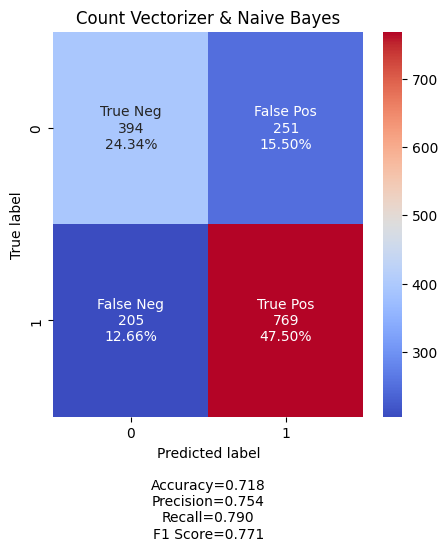

In [27]:
cm_gd = confusion_matrix(y_test, cvec_nb_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer & Naive Bayes"
)

##### 2.1.4 TF-IDF Vectorizer & Naive Bayes

In [28]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50],
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
}

with mlflow.start_run():
    # Instantiate GridSearchCV
    gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                            param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                            cv=10) # 10-fold cross validation

    # Fit model on to training data
    gs_tvec_nb.fit(X_train, y_train)

    # Generate predictions on validation set
    tvec_nb_pred = gs_tvec_nb.predict(X_test)

    signature = infer_signature(X_test, tvec_nb_pred)

    mlflow.log_params(gs_tvec_nb.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, tvec_nb_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, tvec_nb_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, tvec_nb_pred))
    mlflow.log_metric("Precision", precision_score(y_test, tvec_nb_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_tvec_nb,
        "model",
        registered_model_name="TF-IDF Vectorizer & Naive Bayes",
        signature=signature
    )

# Print accuracy scores
print('')
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_nb_pred))

Successfully registered model 'TF-IDF Vectorizer & Naive Bayes'.
2024/11/16 23:47:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TF-IDF Vectorizer & Naive Bayes, version 1
Created version '1' of model 'TF-IDF Vectorizer & Naive Bayes'.
2024/11/16 23:47:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-dolphin-487 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/e24f21f8390a46f7b78f5fc679f9f53d.
2024/11/16 23:47:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7493815234606064
Training score: 0.7657601977750309
Validation score: 0.7387276096355775

              precision    recall  f1-score   support

           0       0.75      0.52      0.61       645
           1       0.73      0.89      0.80       974

    accuracy                           0.74      1619
   macro avg       0.74      0.70      0.71      1619
weighted avg       0.74      0.74      0.73      1619



##### 2.1.5 Count Vectorizer & SVC

In [29]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [2, 3], 
    'cvec__max_df': [.9, .95], 
    'cvec__ngram_range':[(1,1), (1,2)],  
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [3],
    'svc__C': [.1, .01]
}

with mlflow.start_run():
    # Instantiate RandomizedSearchCV
    gs_cvec_svc = RandomizedSearchCV(
                        pipe_cvec_svc, # Objects to optimise
                        param_distributions = pipe_cvec_svc_params, # Hyperparameters for tuning
                        cv=10,
                        n_iter=5,
                        random_state=42,
                    ) # 10-fold cross validation

    # Fit model on to training data
    gs_cvec_svc.fit(X_train, y_train)

    # Generate predictions on validation set
    cvec_svc_pred = gs_cvec_svc.predict(X_test)

    signature = infer_signature(X_test, cvec_svc_pred)

    mlflow.log_params(gs_cvec_svc.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, cvec_svc_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, cvec_svc_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, cvec_svc_pred))
    mlflow.log_metric("Precision", precision_score(y_test, cvec_svc_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_cvec_svc,
        "model",
        registered_model_name="Count Vectorizer & SVC",
        signature=signature
    )


# Print accuracy scores
print('')
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_svc_pred))

Successfully registered model 'Count Vectorizer & SVC'.
2024/11/16 23:52:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Count Vectorizer & SVC, version 1
Created version '1' of model 'Count Vectorizer & SVC'.
2024/11/16 23:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-doe-346 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/1cf48d4a88fa40f6b61fa02c2236d9d0.
2024/11/16 23:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7439702711469842
Training score: 0.7884734239802225
Validation score: 0.7405806053119209

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       645
           1       0.74      0.87      0.80       974

    accuracy                           0.74      1619
   macro avg       0.74      0.71      0.71      1619
weighted avg       0.74      0.74      0.73      1619



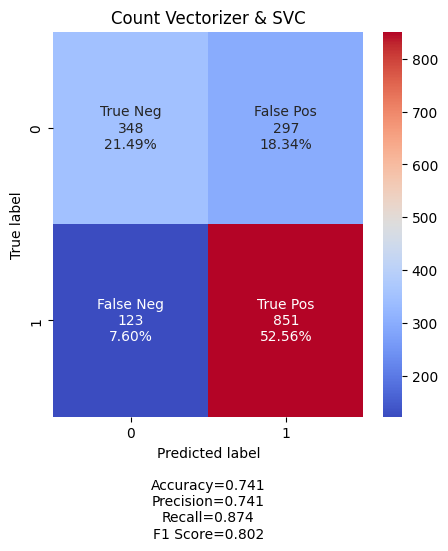

In [36]:
cm_gd = confusion_matrix(y_test, cvec_svc_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer & SVC"
)

##### 2.1.6 TF-IDF Vectorizer & SVC

In [30]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42)) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [3],
    'svc__C': [.1, .01]
}

with mlflow.start_run():
    # Instantiate RandomizedSearchCV
    gs_tvec_svc = RandomizedSearchCV(
                            pipe_tvec_svc, # Objects to optimise
                            param_distributions = pipe_tvec_svc_params, # Hyperparameters for tuning
                            cv=10,
                            n_iter=5,
                            random_state=42,
                    ) # 10-fold cross validation

    # Fit model on to training data
    gs_tvec_svc.fit(X_train, y_train)

    # Generate predictions on validation set
    tvec_svc_pred = gs_tvec_svc.predict(X_test)

    signature = infer_signature(X_test, tvec_svc_pred)

    mlflow.log_params(gs_tvec_svc.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, tvec_svc_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, tvec_svc_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, tvec_svc_pred))
    mlflow.log_metric("Precision", precision_score(y_test, tvec_svc_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_tvec_svc,
        "model",
        registered_model_name="TF-IDF Vectorizer & SVC",
        signature=signature
    )


# Print accuracy scores
print('')
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_svc_pred))

Successfully registered model 'TF-IDF Vectorizer & SVC'.
2024/11/17 00:01:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TF-IDF Vectorizer & SVC, version 1
Created version '1' of model 'TF-IDF Vectorizer & SVC'.
2024/11/17 00:01:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-bird-782 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/029da21ba99e4d00b61c7dc56b384d49.
2024/11/17 00:01:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7337764993226097
Training score: 0.7487639060568603
Validation score: 0.7313156269302038

              precision    recall  f1-score   support

           0       0.82      0.42      0.55       645
           1       0.71      0.94      0.81       974

    accuracy                           0.73      1619
   macro avg       0.76      0.68      0.68      1619
weighted avg       0.75      0.73      0.71      1619



##### 2.1.7 Count Vectorizer & XgBoost

In [31]:
# Create a pipeline with CountVectorizer and XGBClassifier
pipe_cvec_xgb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Define hyperparameters for RandomizedSearchCV
pipe_cvec_xgb_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50], 
    'cvec__max_df': [0.9, 0.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [500, 750, 1000],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.1, 0.01, 0.05],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0]
}

with mlflow.start_run():
    # Instantiate RandomizedSearchCV
    gs_cvec_xgb = RandomizedSearchCV(
                    pipe_cvec_xgb,  # Pipeline to optimize
                    param_distributions=pipe_cvec_xgb_params,  # Hyperparameters for tuning
                    cv=10, 
                    n_iter=5,  # Number of parameter settings that are sampled
                    random_state=42
                )

    # Fit model on to training data
    gs_cvec_xgb.fit(X_train, y_train)

    # Generate predictions on validation set
    cvec_xgb_pred = gs_cvec_xgb.predict(X_test)

    signature = infer_signature(X_test, cvec_xgb_pred)

    mlflow.log_params(gs_cvec_xgb.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, cvec_xgb_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, cvec_xgb_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, cvec_xgb_pred))
    mlflow.log_metric("Precision", precision_score(y_test, cvec_xgb_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_cvec_xgb,
        "model",
        registered_model_name="Count Vectorizer & XGBClassifier",
        signature=signature
    )

# Print accuracy scores
print('')
print('Best CV score: ', gs_cvec_xgb.best_score_)
print('Training score:', gs_cvec_xgb.score(X_train, y_train))
print('Validation score:', gs_cvec_xgb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_xgb_pred))

Successfully registered model 'Count Vectorizer & XGBClassifier'.
2024/11/17 00:02:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Count Vectorizer & XGBClassifier, version 1
Created version '1' of model 'Count Vectorizer & XGBClassifier'.
2024/11/17 00:02:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-goose-604 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/8ecbff288974468c8c6197dd91e9ebc3.
2024/11/17 00:02:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7430445837388134
Training score: 0.8216934487021014
Validation score: 0.7263743051266214

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       645
           1       0.73      0.85      0.79       974

    accuracy                           0.73      1619
   macro avg       0.72      0.69      0.70      1619
weighted avg       0.72      0.73      0.72      1619



Thresholding makes the recall for the negative class a lot better overall, though Accuracy and Macro Average recall hasn't improved at all.

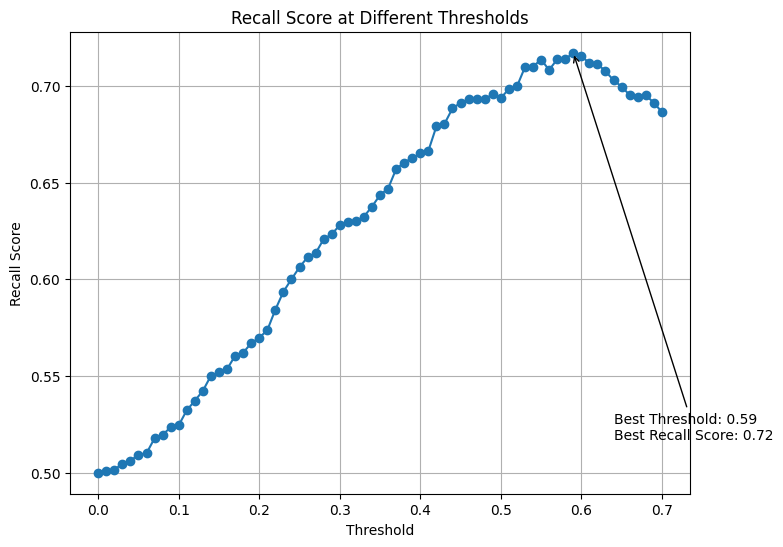

Best Threshold:  0.59
Acc Score:  0.7183446571957999
Roc Auc Score:  0.7172102573898095
Precision Score:  0.7910112359550562
Recall Score:  0.7227926078028748
f1 score:  0.7553648068669528
LightGBM confusion matrix on test data  
 [[459 186]
 [270 704]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       645
           1       0.79      0.72      0.76       974

    accuracy                           0.72      1619
   macro avg       0.71      0.72      0.71      1619
weighted avg       0.73      0.72      0.72      1619

_____________________________________________________



In [34]:
# Obtain the predicted probabilities for each class on the test set
probs=gs_cvec_xgb.predict_proba(X_test)

# Define a range of threshold values to try
thresholds = np.arange(0, 0.71, 0.01)

# Initialize variables to store F1 scores
recall_scores = []

# Iterate over the threshold values and evaluate the model's performance
for threshold in thresholds:
    preds = (probs[:, 1] > threshold).astype(int)
    score = recall_score(y_test, preds, average='macro')
    recall_scores.append(score)

# Find the best threshold and its corresponding F1 score
best_threshold = thresholds[np.argmax(recall_scores)]
best_score = max(recall_scores)

# Plot the F1 scores at different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall_scores, marker='o')
plt.title("Recall Score at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Recall Score")
plt.grid(True)

# Mark the best threshold on the chart
plt.annotate(f"Best Threshold: {best_threshold:.2f}\nBest Recall Score: {best_score:.2f}",
             xy=(best_threshold, best_score),
             xytext=(best_threshold + 0.05, best_score - 0.2),
             arrowprops=dict(arrowstyle='->'))

# Show the plot
plt.show()

# Use the best threshold to predict the test set and evaluate the model's performance
preds2 = (gs_cvec_xgb.predict_proba(X_test)[:,1] > best_threshold).astype(int)

print('Best Threshold: ', best_threshold)
print('Acc Score: ', accuracy_score(y_test, preds2))
print('Roc Auc Score: ', roc_auc_score(y_test, preds2))
print('Precision Score: ', precision_score(y_test, preds2))
print('Recall Score: ', recall_score(y_test, preds2))
print('f1 score: ', f1_score(y_test, preds2))
print('LightGBM confusion matrix on test data  \n', confusion_matrix(y_test, preds2) )
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds2))
print('_____________________________________________________')
print("")

##### 2.1.8 TF-IDF Vectorizer & XgBoost

In [33]:
# Create a pipeline with TF-IDF Vectorizer and XGBClassifier
pipe_tvec_xgb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Define hyperparameters for RandomizedSearchCV
pipe_tvec_xgb_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50], 
    'tvec__max_df': [0.9, 0.95], 
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [500, 750, 1000],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.1, 0.01, 0.05],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0]
}

with mlflow.start_run():
    # Instantiate RandomizedSearchCV
    gs_tvec_xgb = RandomizedSearchCV(
                    pipe_tvec_xgb,  # Pipeline to optimize
                    param_distributions=pipe_tvec_xgb_params,  # Hyperparameters for tuning
                    cv=10, 
                    n_iter=5,  # Number of parameter settings that are sampled
                    random_state=42
                )

    # Fit model on to training data
    gs_tvec_xgb.fit(X_train, y_train)

    # Generate predictions on validation set
    tvec_xgb_pred = gs_tvec_xgb.predict(X_test)

    signature = infer_signature(X_test, tvec_xgb_pred)

    mlflow.log_params(gs_tvec_xgb.best_params_)
    mlflow.log_metric("F1-Score", f1_score(y_test, tvec_xgb_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, tvec_xgb_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, tvec_xgb_pred))
    mlflow.log_metric("Precision", precision_score(y_test, tvec_xgb_pred, average='macro'))

    mlflow.sklearn.log_model(
        gs_tvec_xgb,
        "model",
        registered_model_name="TF-IDF Vectorizer & XGBClassifier",
        signature=signature
    )

# Print accuracy scores
print('')
print('Best CV score: ', gs_tvec_xgb.best_score_)
print('Training score:', gs_tvec_xgb.score(X_train, y_train))
print('Validation score:', gs_tvec_xgb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_xgb_pred))

Successfully registered model 'TF-IDF Vectorizer & XGBClassifier'.
2024/11/17 00:08:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TF-IDF Vectorizer & XGBClassifier, version 1
Created version '1' of model 'TF-IDF Vectorizer & XGBClassifier'.
2024/11/17 00:08:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-loon-13 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/52d9cc319f8b4072934d2ae25424f55f.
2024/11/17 00:08:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Best CV score:  0.7416533096723719
Training score: 0.8447156983930779
Validation score: 0.7251389746757257

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       645
           1       0.73      0.86      0.79       974

    accuracy                           0.73      1619
   macro avg       0.72      0.69      0.70      1619
weighted avg       0.72      0.73      0.71      1619



##### 2.1.9 Voting Classifier (Logistic Regression & Naive Bayes)

Given that Logistic Regression and Naive Bayes are rather different algorithms, we will use ensemble learning in an attempt to improve our model's accuracy and recall. We will use a Voting Classifier where the winning class will be determined by soft voting. As the Naive Bayes returned a slightly more balanced recall rate than Logistic Regression, we will give a higher voting weight to the Naive Bayes than the Logistic Regression.

**While SVC performs marginally better than Logistic Regression (Precision wise), we opt for Logistic Regression due to it having a `.predict_proba()` method which is important for 'soft' voting.*

In [39]:
# Instantiate the Voting Classifier with TF-IDF Logistic Regression and SVC
voting_clf = VotingClassifier(
    estimators=[('cvec_lr', gs_cvec_lr),
                ('cvec_nb', gs_cvec_nb)], 
    voting='soft',
    weights=[1.5, 2]
)

with mlflow.start_run():
    # Fit model on to training data
    voting_clf.fit(X_train, y_train)

    # Generate predictions on validation set
    voting_pred = voting_clf.predict(X_test)

    signature = infer_signature(X_test, voting_pred)

    mlflow.log_metric("F1-Score", f1_score(y_test, voting_pred, average='macro'))
    mlflow.log_metric("Recall", recall_score(y_test, voting_pred, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(y_test, voting_pred))
    mlflow.log_metric("Precision", precision_score(y_test, voting_pred, average='macro'))

    mlflow.sklearn.log_model(
        voting_clf,
        "model",
        registered_model_name="Voting Classifier (Logistic Regression & Naive Bayes)",
        signature=signature
    )

# Print accuracy scores
print('')
print('Training score:', voting_clf.score(X_train, y_train))
print('Validation score:', voting_clf.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, voting_pred))

Successfully registered model 'Voting Classifier (Logistic Regression & Naive Bayes)'.
2024/11/17 00:37:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Voting Classifier (Logistic Regression & Naive Bayes), version 1
Created version '1' of model 'Voting Classifier (Logistic Regression & Naive Bayes)'.
2024/11/17 00:37:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-worm-543 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/a45f35f9e3444a5989c36d33d90a2e79.
2024/11/17 00:37:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.



Training score: 0.7697775030902348
Validation score: 0.721432983323039

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       645
           1       0.75      0.81      0.78       974

    accuracy                           0.72      1619
   macro avg       0.71      0.70      0.70      1619
weighted avg       0.72      0.72      0.72      1619



##### 2.1.10 Select best model & save to Pickle format

From our [MLflow experiment](https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/compare-runs?runs=[%221cf48d4a88fa40f6b61fa02c2236d9d0%22,%22e24f21f8390a46f7b78f5fc679f9f53d%22,%22636046f0cab54aaab2198516355bd8ea%22,%22029da21ba99e4d00b61c7dc56b384d49%22,%224208a7b71def45d692fc1d2a1f26207d%22,%228ecbff288974468c8c6197dd91e9ebc3%22,%2252d9cc319f8b4072934d2ae25424f55f%22,%2279363a6b65b64c2cbd8446bf92e62a25%22,%225264f1d5ccea4ae9af208196d7095172%22]&experiments=[%221%22]), while the models don't vary much performance wise, we find the SVC and Count Vectorizer model performing consistently high across all 4 metrics (F1-Score, Accuracy, Precision and Recall).

In the future, should we require more balanced performance, we can experiment with adjusting the probability threshold for each classifier (except for SVC).

In [37]:
with open('../models/svc_stem_v20241117.pkl', 'wb') as file:
    pickle.dump(gs_cvec_svc, file)

#### 2.2 Deep Learning

##### 2.2.0 Load datasets & check GPU

In [47]:
# Read the clean dataset
reviews = pd.read_csv('../data/clean_train_stem.csv')

In [48]:
X = reviews['content_stem']
y = reviews['target']

In [42]:
# Perform train test split so that we can train, score and tune our models' hyperparameters 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [10]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [44]:
!nvidia-smi

Sun Nov 17 00:37:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P3              8W /   45W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##### 2.2.1 Build `vocab`

Since the following libraries from `torchtext` aren't available, we'll be looking at their repo and attempting to replicate the below tokenizer and vocabulary creation functions as closely as possible.

> `from torchtext.data.utils import get_tokenizer`    
> `from torchtext.vocab import build_vocab_from_iterator`

We get the below `get_tokenizer()` from this section in their GitHub: https://github.com/pytorch/text/blob/main/torchtext/data/utils.py

In [16]:
_patterns = [r"\'", r"\"", r"\.", r"<br \/>", r",", r"\(", r"\)", r"\!", r"\?", r"\;", r"\:", r"\s+"]

_replacements = [" '  ", "", " . ", " ", " , ", " ( ", " ) ", " ! ", " ? ", " ", " ", " "]

_patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))

In [17]:
def get_tokenizer(line: str) -> List[str]:
    r"""
    Basic normalization for a line of text.
    Normalization includes
    - lowercasing
    - complete some basic text normalization for English words as follows:
        add spaces before and after '\''
        remove '\"',
        add spaces before and after '.'
        replace '<br \/>'with single space
        add spaces before and after ','
        add spaces before and after '('
        add spaces before and after ')'
        add spaces before and after '!'
        add spaces before and after '?'
        replace ';' with single space
        replace ':' with single space
        replace multiple spaces with single space

    Returns a list of tokens after splitting on whitespace.
    """

    line = line.lower()
    for pattern_re, replaced_str in _patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()

In [47]:
# Tokenize the data
X_train_tokens = [get_tokenizer(text) for text in X_train]
X_val_tokens = [get_tokenizer(text) for text in X_test]

We now try to build our own version of `build_vocab_from_iterator()`. The code creates a mapping from words to indices based on their frequency in the training data, while reserving special indices for padding and unknown words. This vocabulary can be used later to encode input sequences for use in a model, such as converting words to integers before feeding them into an embedding layer or any other type of model input.

In [48]:
# Flatten and count the words
max_words = 1500

all_words = list(chain.from_iterable(X_train_tokens))
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(max_words)

# Create word to index mapping
vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common_words)}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

In [49]:
# Print first 10 key-value pairs in `vocab`
for key, value in islice(vocab.items(), 10):
    print(key, value)

get 2
time 3
quest 4
graphic 5
one 6
also 7
phone 8
star 9
new 10
amaz 11


In [50]:
# size of vocab
len(vocab)

1502

In [51]:
# Save the vocab dictionary as a pickle file
with open('../models/pytorch_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

##### 2.2.2 Create `GenshinDataset` & `SentimentRNN` Class

In [18]:
# Load the vocab dictionary from the pickle file
with open('../models/pytorch_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [19]:
class GenshinDataset(Dataset):
    def __init__(self, file_path_or_df, vocab):
        if isinstance(file_path_or_df, str):
            # Load CSV if a file path is provided
            self.data = pd.read_csv(file_path_or_df)
        else:
            # Assume input is a DataFrame
            self.data = file_path_or_df
            
        self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Access the "content_stem" and "target" columns
        content = self.data.loc[idx].content_stem
        target = self.data.loc[idx].target
        
        # Convert "content_stem" to numerical tokens using the vocabulary
        # Assuming content is a string of space-separated tokens
        tokens = [get_tokenizer(text)[0] for text in content.split()]
        numerical_tokens = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        
        return torch.tensor(numerical_tokens, dtype=torch.int), target

In [20]:
class SentimentRNN(nn.Module):
    def __init__(self,
            no_layers,
            vocab_size,
            output_dim,
            hidden_dim,
            embedding_dim,
            drop_prob=0.5,
        ):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        # initialize hidden state
        hidden = self.init_hidden(batch_size)

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True

        # print(embeds.shape)  # e.g., [50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        # get last batch of labels
        sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        '''
        Initializes hidden state: https://discuss.pytorch.org/t/how-to-handle-last-batch-in-lstm-hidden-state/40858
        '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        
        hidden = (h0,c0)

        return hidden

##### 2.2.3 Train & save the model

In [33]:
# initialize model parameters
no_layers = 2
vocab_size = len(vocab)
embedding_dim = 64
output_dim = 1
hidden_dim = 256
batch_size = 50
clip = 5
epochs = 100
valid_loss_min = np.Inf
learning_rate = 0.001
weight_decay = 1e-5

In [34]:
def collate_fn(batch):
    # Separate inputs and targets from batch
    inputs, targets = zip(*batch)
    
    # Pad the inputs to the max length within the batch
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)  # Assumes <pad> index is 0
    
    # Convert targets to a tensor (if they're labels, they don't need padding)
    targets = torch.tensor(targets)
    
    return padded_inputs, targets

In [35]:
# Create data loaders for the training and validation sets
train_dataset = GenshinDataset('../data/clean_train_stem.csv', vocab)
valid_dataset = GenshinDataset('../data/clean_test_stem.csv', vocab)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [36]:
model = SentimentRNN(
    no_layers=no_layers,
    vocab_size=vocab_size,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    drop_prob=0.6
)

# moving to gpu
model.to(device)

SentimentRNN(
  (embedding): Embedding(1502, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [37]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [38]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [39]:
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

best_dev_acc = -np.inf
patient = 3
current_patient = 0

with mlflow.start_run():
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)   

            model.zero_grad()
            output, h = model(inputs)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())

            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        with torch.no_grad():
            model.eval()

            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0

            val_outputs = []

            for inputs, labels in valid_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = model(inputs)

                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                val_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                    .int().numpy().tolist())

                accuracy = acc(output,labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        # Print epoch progress
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # implement early stopping if we see no gains in Val. accuracy
        if epoch_val_acc >= best_dev_acc:
            best_dev_acc = epoch_val_acc
            current_patient = 0
            torch.save(model.state_dict(), '../models/rnn_pytorch_stem_v20241117.pth')
            
        else:
            current_patient += 1
        
        if current_patient >= patient:
            break

    mlflow.log_artifact(local_path="../models/pytorch_vocab.pkl")

    mlflow.log_param('epoch', epoch - current_patient)
    mlflow.log_param('no_layers', no_layers)
    mlflow.log_param('vocab_size', vocab_size)
    mlflow.log_param('embedding_dim', embedding_dim)
    mlflow.log_param('output_dim', output_dim)
    mlflow.log_param('hidden_dim', hidden_dim)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('clip', clip)
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('valid_loss_min', valid_loss_min)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('weight_decay', weight_decay)

    reviews_val = pd.read_csv('../data/clean_test_stem.csv')

    mlflow.log_metric("F1-Score", f1_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Recall", recall_score(reviews_val['target'], val_outputs, average='macro'))
    mlflow.log_metric("Accuracy", accuracy_score(reviews_val['target'], val_outputs))
    mlflow.log_metric("Precision", precision_score(reviews_val['target'], val_outputs, average='macro'))

    mlflow.pytorch.log_model(
        model,
        "model",
        registered_model_name="PyTorch LSTM",
    )

Epoch [1/100], Train Loss: 0.6747, Train Acc: 0.6014, Val Loss: 0.6722, Val Acc: 0.6016
Epoch [2/100], Train Loss: 0.6718, Train Acc: 0.5997, Val Loss: 0.6647, Val Acc: 0.6016
Epoch [3/100], Train Loss: 0.6606, Train Acc: 0.6060, Val Loss: 0.6501, Val Acc: 0.6337
Epoch [4/100], Train Loss: 0.6565, Train Acc: 0.6222, Val Loss: 0.6520, Val Acc: 0.6350
Epoch [5/100], Train Loss: 0.6465, Train Acc: 0.6482, Val Loss: 0.6438, Val Acc: 0.6516
Epoch [6/100], Train Loss: 0.6399, Train Acc: 0.6525, Val Loss: 0.6409, Val Acc: 0.6448
Epoch [7/100], Train Loss: 0.6383, Train Acc: 0.6584, Val Loss: 0.6456, Val Acc: 0.6455
Epoch [8/100], Train Loss: 0.6256, Train Acc: 0.6629, Val Loss: 0.6345, Val Acc: 0.6628
Epoch [9/100], Train Loss: 0.6015, Train Acc: 0.6917, Val Loss: 0.6186, Val Acc: 0.6683
Epoch [10/100], Train Loss: 0.5969, Train Acc: 0.6865, Val Loss: 0.6159, Val Acc: 0.6770
Epoch [11/100], Train Loss: 0.5435, Train Acc: 0.7299, Val Loss: 0.5854, Val Acc: 0.7035
Epoch [12/100], Train Loss: 0.

2024/11/17 01:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'PyTorch LSTM' already exists. Creating a new version of this model...
2024/11/17 01:17:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PyTorch LSTM, version 3
Created version '3' of model 'PyTorch LSTM'.
2024/11/17 01:17:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-elk-346 at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1/runs/03438d7d03344701b5116161b9b1ce52.
2024/11/17 01:17:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/wanadzhar913/genshin-impact-reviews-sentiment-analysis-fastapi-docker.mlflow/#/experiments/1.


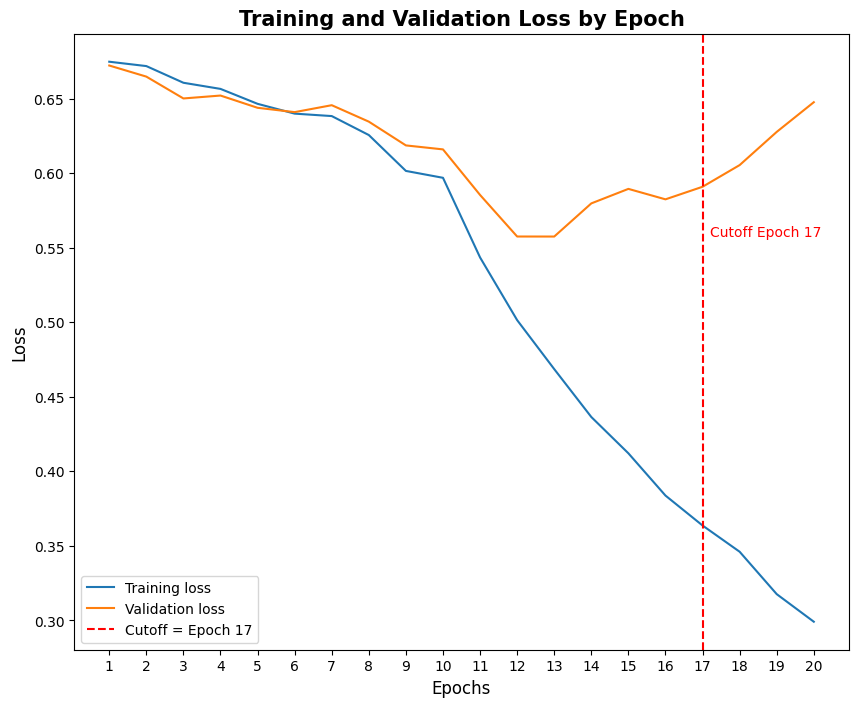

In [42]:
# Plot the training and validation loss by epoch

plt.figure(figsize=(10,8))
epochs = range(1,21)
plt.plot(epochs, epoch_tr_loss, label='Training loss')
plt.plot(epochs, epoch_vl_loss, label='Validation loss')
plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.xticks(np.arange(1,21,1))

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = 17
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_loss), f'Cutoff Epoch {best_epoch}', color='red')

plt.legend();

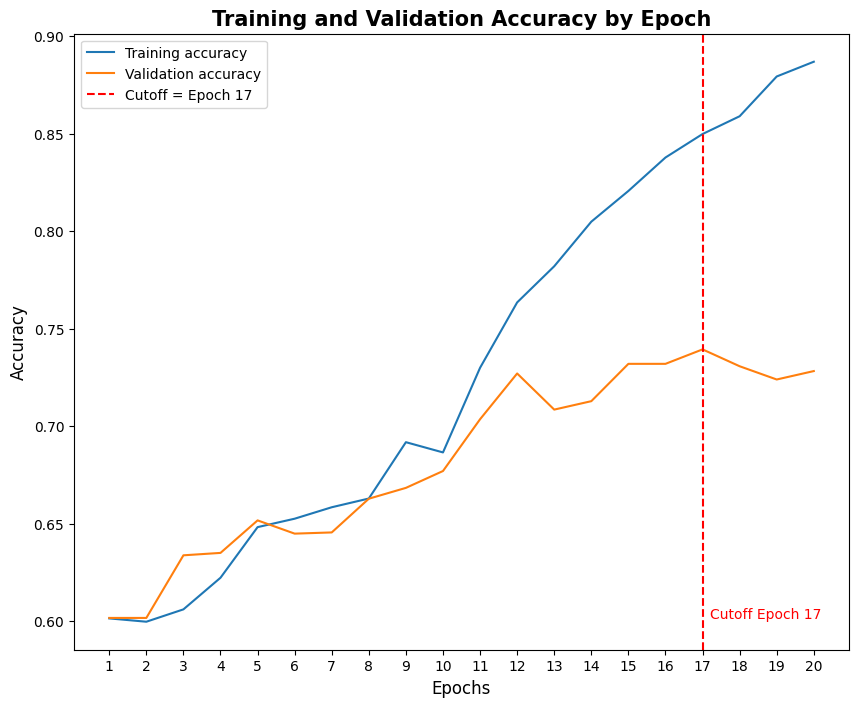

In [43]:
# Plot the training and validation accuracy by epoch

plt.figure(figsize=(10,8))
epochs = range(1,21)
plt.plot(epochs, epoch_tr_acc, label='Training accuracy')
plt.plot(epochs, epoch_vl_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')

# Specify the best epoch or cutoff epoch (example: 15)
best_epoch = 17
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Cutoff = Epoch {best_epoch}')
plt.text(best_epoch + 0.2, min(epoch_vl_acc), f'Cutoff Epoch {best_epoch}', color='red')

plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.xticks(np.arange(1,21,1))

plt.legend();

##### 2.2.4 Benchmark Performance on Validation Set

In [44]:
train_loader_unshuffled = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [45]:
train_outputs = []

with torch.no_grad():
        model.eval()

        for inputs, labels in train_loader_unshuffled:

                inputs, labels = inputs.to(device), labels.to(device)

                output, train_noshuf_h = model(inputs)

                train_outputs.extend(torch.round(output.squeeze()).cpu().detach() \
                                                        .int().numpy().tolist())

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2576
           1       0.91      0.94      0.93      3896

    accuracy                           0.91      6472
   macro avg       0.91      0.90      0.91      6472
weighted avg       0.91      0.91      0.91      6472



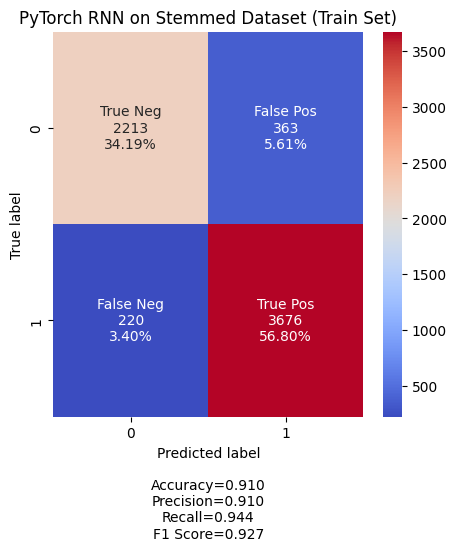

In [49]:
# Print classification report and confusion matrix for Train Set
print(classification_report(reviews['target'], train_outputs))

cm_gd = confusion_matrix(reviews['target'], train_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'], 
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch RNN on Stemmed Dataset (Train Set)"
)

In [50]:
reviews_val = pd.read_csv('../data/clean_test_stem.csv')

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       645
           1       0.75      0.83      0.79       974

    accuracy                           0.73      1619
   macro avg       0.72      0.70      0.71      1619
weighted avg       0.72      0.73      0.72      1619



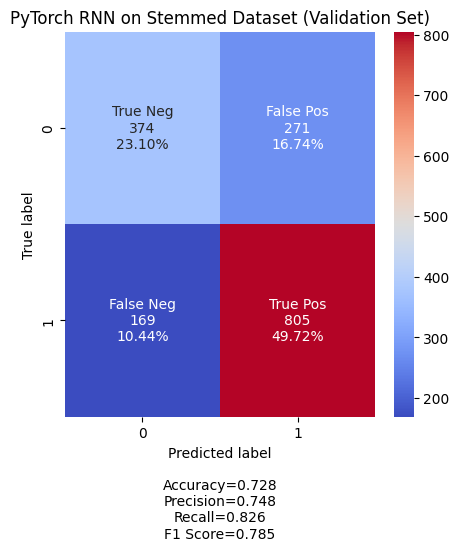

In [51]:
# Print classification report and confusion matrix for Validation Set
print(classification_report(reviews_val['target'], val_outputs))

cm_gd = confusion_matrix(reviews_val['target'], val_outputs)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'], 
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "PyTorch RNN on Stemmed Dataset (Validation Set)"
)

In [ ]:
# model = SentimentRNN(
#     no_layers = 2,
#     vocab_size = 1502,
#     output_dim = 1,
#     hidden_dim = 256,
#     embedding_dim = 64,
#     drop_prob=0.6
# )

# model.load_state_dict(torch.load('..models/rnn_pytorch_stem_v20241117.pth'))

# model.eval().cuda()